<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Multivariate_Random_Forest_for_bridging_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multivariate Random Forest

https://github.com/souhirbenamor/Electricity_Price_Forecating/blob/main/Collected%20codes/ARIMA%2BMultivariate%20RF%2B%20Multivariate%20LSTM%2B%20Naive%20model%2B%20Python/Random_Forest%20(1).ipynb


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

In [ ]:
df = pd.read_excel('/content/electricty_fund_selected_data 2.xlsx')
df.drop(df.loc[df['Date'].duplicated()].index, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

# df = df.sort_values(df['datetime'], ascending=[True])
df.set_index(df['Date'], inplace = True)
df.drop(columns = [ 'Date'], inplace = True)
df

,price day ahead Model,Demand DE,Wind,PV,Gas,Coal,CO2
Date,,,,,,,
2014-12-31 23:59:59.991,25.390297,40242.25,8280.00,0.0,21.30,55.17,7.27
2015-01-01 00:59:59.991,24.980000,39158.50,8412.75,0.0,21.30,55.17,7.27
2015-01-01 01:59:59.991,24.796874,38824.50,8502.25,0.0,21.30,55.17,7.27
2015-01-01 02:59:59.991,26.074430,38969.25,8668.50,0.0,21.30,55.17,7.27
2015-01-01 03:59:59.991,20.377994,39092.75,8849.25,0.0,21.30,55.17,7.27
...,...,...,...,...,...,...,...
2020-12-31 18:59:59.980,56.545811,49516.00,8053.50,0.0,19.12,56.49,32.59
2020-12-31 19:59:59.980,50.781170,47747.50,7456.50,0.0,19.12,56.49,32.59
2020-12-31 20:59:59.980,50.781170,47761.75,6902.50,0.0,19.12,56.49,32.59


In [ ]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

In [ ]:
df.head()

,price day ahead Model,Demand DE,Wind,PV,Gas,Coal,CO2
Date,,,,,,,
2014-12-31 23:59:59.991,25.390297,40242.25,8280.00,0.0,21.3,55.17,7.27
2015-01-01 00:59:59.991,24.980000,39158.50,8412.75,0.0,21.3,55.17,7.27
2015-01-01 01:59:59.991,24.796874,38824.50,8502.25,0.0,21.3,55.17,7.27
2015-01-01 02:59:59.991,26.074430,38969.25,8668.50,0.0,21.3,55.17,7.27
2015-01-01 03:59:59.991,20.377994,39092.75,8849.25,0.0,21.3,55.17,7.27


In [ ]:
df_lagged = table2lags(df, 168, 24)

In [ ]:
df_lagged.columns

Index(['price day ahead Model_24', 'Demand DE_24', 'Wind_24', 'PV_24',
       'Gas_24', 'Coal_24', 'CO2_24', 'price day ahead Model_25',
       'Demand DE_25', 'Wind_25',
       ...
       'Gas_167', 'Coal_167', 'CO2_167', 'price day ahead Model_168',
       'Demand DE_168', 'Wind_168', 'PV_168', 'Gas_168', 'Coal_168',
       'CO2_168'],
      dtype='object', length=1015)

In [ ]:
df_lagged.shape

(52608, 1015)

In [ ]:
x_train = df_lagged[168:25000]
x_valid = df_lagged[25000:34944]
x_test = df_lagged[34944:]

In [ ]:
y_train = df['price day ahead Model'][168:25000]
y_valid = df['price day ahead Model'][25000:34944]
y_test = df['price day ahead Model'][34944:]

In [ ]:
x_test.head()

,price day ahead Model_24,Demand DE_24,Wind_24,PV_24,Gas_24,Coal_24,CO2_24,price day ahead Model_25,Demand DE_25,Wind_25,...,Gas_167,Coal_167,CO2_167,price day ahead Model_168,Demand DE_168,Wind_168,PV_168,Gas_168,Coal_168,CO2_168
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-26 23:59:59.983,36.613695,45359.375,21770.50,0.0,24.25,76.65,24.9,37.392000,48533.125,22085.00,...,24.6,77.74,24.23,42.885549,47106.236493,12341.50,0.0,24.6,77.74,24.23
2018-12-27 00:59:59.983,36.613695,44483.125,21419.75,0.0,24.25,76.65,24.9,36.613695,45359.375,21770.50,...,24.6,77.74,24.23,40.000000,46271.970777,12261.75,0.0,24.6,77.74,24.23
2018-12-27 01:59:59.983,35.000000,44814.625,21025.75,0.0,24.25,76.65,24.9,36.613695,44483.125,21419.75,...,24.6,77.74,24.23,38.787155,46461.589810,12411.50,0.0,24.6,77.74,24.23
2018-12-27 02:59:59.983,35.170000,46157.000,20383.50,0.0,24.25,76.65,24.9,35.000000,44814.625,21025.75,...,24.6,77.74,24.23,41.899859,47481.164035,12726.75,0.0,24.6,77.74,24.23
2018-12-27 03:59:59.983,36.613695,49332.625,19661.00,0.0,24.25,76.65,24.9,35.170000,46157.000,20383.50,...,24.6,77.74,24.23,46.457118,50174.786288,13373.50,0.0,24.6,77.74,24.23


In [ ]:
rf = RandomForestRegressor(n_estimators=10, max_features=2,
    criterion='mae',
    max_depth=1)

    
rf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mae', max_depth=1, max_features=2,
                      n_estimators=10)

In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
y_test['predictions'] = y_pred

In [ ]:
y_test['difference'] = np.abs(y_test['price day ahead Model'] - y_test['predictions'])
y_test['% error'] = (y_test['difference']/y_test['price day ahead Model'])*100
np.mean(y_test['% error'])

23.349760152590097

In [ ]:
y_test['% error'] = (y_test['difference']/y_test['price day ahead Model'])*100

In [ ]:
y_test

,price day ahead Model,predictions,difference,% error
Date,,,,
2018-12-26 23:59:59.983,39.219525,35.413279,3.806245,9.704976
2018-12-27 00:59:59.983,36.613695,35.413279,1.200416,3.278598
2018-12-27 01:59:59.983,36.613695,34.610075,2.003620,5.472325
2018-12-27 02:59:59.983,36.613695,34.610075,2.003620,5.472325
2018-12-27 03:59:59.983,39.219525,34.610075,4.609450,11.752947
...,...,...,...,...
2020-12-31 18:59:59.980,56.545811,34.683887,21.861923,38.662322
2020-12-31 19:59:59.980,50.781170,34.513637,16.267534,32.034578
2020-12-31 20:59:59.980,50.781170,34.161386,16.619784,32.728242


In [ ]:
np.mean(y_test['% error'])

23.349760152590097

In [ ]:
y_test.drop(y_test.loc[y_test['% error'] > 2000].index, inplace = True)

In [ ]:
np.mean(np.abs(y_test['price day ahead Model'] - y_test['predictions']) * 100)

1016.0430352406307

In [ ]:
#save prediction results
y_test.to_excel("Random_forest_results.xlsx", header=True)

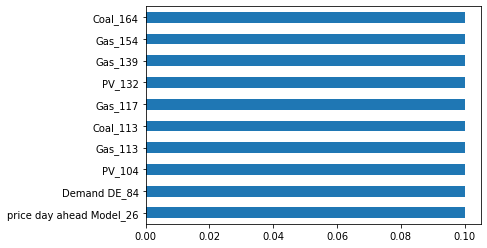

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=df_lagged.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
gridsearch = {'bootstrap': [True],
     'max_depth': [10, 250],
     'min_samples_leaf': [2, 5],
     'n_estimators': [100, 200]}
# print(gridsearch)
# {'bootstrap': [True],
#  'max_depth': [10, 50, 250,1000],
#  'max_features': [2, 'sqrt'],
#  'min_samples_leaf': [1, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 1000, 2000]}

In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_GridSearch = GridSearchCV(
 estimator = rf, 
 param_grid = gridsearch, 
 cv = 2,
 verbose=2, 
 n_jobs = 1)

In [ ]:
rf_GridSearch.fit(x_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100; total time= 9.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100; total time= 9.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200; total time=19.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=200; total time=19.1min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 9.7min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 9.4min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=19.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=18.8min
[CV] END bootstrap=True, max_depth=250, min_samples_leaf=2, n_estimators=100; total time=15.6min
[CV] END bootstrap=True, max_depth=250, min_samples_leaf=2, n_estimators=10

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 250],
                         'min_samples_leaf': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [ ]:
print(rf_GridSearch.best_score_)
print(rf_GridSearch.best_params_)

0.5525190912228477
{'bootstrap': True, 'max_depth': 250, 'min_samples_leaf': 5, 'n_estimators': 200}


In [ ]:
rf = RandomForestRegressor(n_estimators=250, max_features=5,
    criterion='mae',
    max_depth=15)

    
rf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


In [ ]:
prediciton = rf.predict(x_test)

In [ ]:
prediciton = pd.DataFrame(prediciton)

prediciton.to_csv('randomforestprediction.csv')

In [ ]:
prediciton.to_excel("Random_forest_GridSearch_results.xlsx", header=True)

In [ ]:
len(prediciton)

17472

In [ ]:
len(x_test)

17472

In [ ]:
x_test.isna().sum()

 Prices_24                   0
 Generation forecast_24      0
 System load forecast_24     0
 Prices_25                   0
 Generation forecast_25      0
                            ..
 Generation forecast_167     0
 System load forecast_167    0
 Prices_168                  0
 Generation forecast_168     0
 System load forecast_168    0
Length: 435, dtype: int64

In [ ]:
y_test

,Prices,predictions,difference,% error
Date,,,,
2015-01-04 00:00:00,36.26,50.051,13.791,38.033646
2015-01-04 01:00:00,32.28,50.051,17.771,55.052664
2015-01-04 02:00:00,27.63,50.051,22.421,81.147304
2015-01-04 03:00:00,27.03,50.972,23.942,88.575657
2015-01-04 04:00:00,27.04,50.972,23.932,88.505917
...,...,...,...,...
2016-12-31 19:00:00,40.84,50.468,9.628,23.574927
2016-12-31 20:00:00,40.10,50.468,10.368,25.855362
2016-12-31 21:00:00,36.00,49.547,13.547,37.630556


In [ ]:
prediciton = y_test.iloc[:,:2]

In [ ]:
prediciton

,Prices,predictions
Date,,
2015-01-04 00:00:00,36.26,50.051
2015-01-04 01:00:00,32.28,50.051
2015-01-04 02:00:00,27.63,50.051
2015-01-04 03:00:00,27.03,50.972
2015-01-04 04:00:00,27.04,50.972
...,...,...
2016-12-31 19:00:00,40.84,50.468
2016-12-31 20:00:00,40.10,50.468
2016-12-31 21:00:00,36.00,49.547


In [ ]:
prediciton.rename(columns = {0:'prediction'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
prediciton['difference'] = np.abs(prediciton[' Prices'] - prediciton['predictions'])
prediciton['% error'] = ((prediciton['difference'] + 0.5) /(prediciton[' Prices'] + 0.5))*100
# np.mean(prediciton['% error'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
prediciton['% error'].mean()

52.35479330194306

In [ ]:
from numpy import inf

In [ ]:
prediciton.loc[prediciton['% error'] == 36798.27999999999]

,Prices,predictions,difference,% error
Date,,,,


In [ ]:
mape = 100 * (prediciton['difference'] / prediciton[' Prices'])
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
100 - accuracy

55.01910014432107

In [ ]:
prediciton['% error'] = mape

In [ ]:
np.mean(mape[np.isfinite(mape)])

55.01910014432107

In [ ]:
mape

Date
2015-01-04 00:00:00    38.033646
2015-01-04 01:00:00    55.052664
2015-01-04 02:00:00    81.147304
2015-01-04 03:00:00    88.575657
2015-01-04 04:00:00    88.505917
                         ...    
2016-12-31 19:00:00    23.574927
2016-12-31 20:00:00    25.855362
2016-12-31 21:00:00    37.630556
2016-12-31 22:00:00    41.094286
2016-12-31 23:00:00    44.728105
Length: 17465, dtype: float64

In [ ]:
mape[np.isfinite(mape)].mean()

55.01910014432107

In [ ]:
# Save prediction as CSV
import pandas as pd
from pandas import read_csv
import csv
y_pred=prediciton
y_pred=pd.DataFrame(y_pred)
print(y_pred)
y_pred.to_csv("y_pred.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

                      Prices  predictions  difference    % error
Date                                                            
2015-01-04 00:00:00    36.26       50.051      13.791  38.033646
2015-01-04 01:00:00    32.28       50.051      17.771  55.052664
2015-01-04 02:00:00    27.63       50.051      22.421  81.147304
2015-01-04 03:00:00    27.03       50.972      23.942  88.575657
2015-01-04 04:00:00    27.04       50.972      23.932  88.505917
...                      ...          ...         ...        ...
2016-12-31 19:00:00    40.84       50.468       9.628  23.574927
2016-12-31 20:00:00    40.10       50.468      10.368  25.855362
2016-12-31 21:00:00    36.00       49.547      13.547  37.630556
2016-12-31 22:00:00    35.00       49.383      14.383  41.094286
2016-12-31 23:00:00    34.94       50.568      15.628  44.728105

[17465 rows x 4 columns]
